# CNN-GPR Model

This workbook contains the combined CNN-GPR model used to provide a probalistic prediticion of Li-ion battery state of health from partial charge data.

In [1]:
import os
dir_path = os.getcwd()

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from matplotlib.ticker import FormatStrFormatter

import scripts.process_B6_data as pcs
import scripts.ML_plotting as mlplt

In [3]:
Use_cpu = True

import tensorflow as tf
if Use_cpu:
    import os
    # Prevents Tensorflow from using the GPU
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
else:
    from tensorflow.compat.v1 import ConfigProto
    from tensorflow.compat.v1 import InteractiveSession
    config = ConfigProto()
    config.gpu_options.allow_growth = True
    session = InteractiveSession(config=config)
    
import keras
from keras import layers
from tensorflow.keras.utils import plot_model

import gpflow
import gpflux
from gpflow.utilities import print_summary
from gpflow.config import default_float

tf.keras.backend.set_floatx("float64")

# Load Data

In [4]:
def load_np_Test_Data(data_name):
    return np.load(os.path.join(dir_path, 'Data', '') + data_name + '.npy', allow_pickle=True)

In [5]:
# Load training, validation, and MG data sets without the temperature data
cap_train_features = load_np_Test_Data('train_features_new').astype('float64')
cap_val_features = load_np_Test_Data('val_features_new').astype('float64')
cap_MG_features = load_np_Test_Data('MG_features_new').astype('float64')
train_labels = load_np_Test_Data('train_labels_new').astype('float64')
val_labels = load_np_Test_Data('val_labels_new').astype('float64')
MG_labels = load_np_Test_Data('MG_labels_new').astype('float64')

In [6]:
# Mak SOC min and max values for full charge segments
SOC_min_features = np.zeros((train_labels.shape[0],1))
SOC_max_features = np.ones((train_labels.shape[0],1))
SOC_min_val = np.zeros((val_labels.shape[0],1))
SOC_max_val = np.ones((val_labels.shape[0],1))
SOC_min_MG = np.zeros((MG_labels.shape[0],1))
SOC_max_MG = np.ones((MG_labels.shape[0],1))

In [7]:
cap_train_features.shape

(153, 465, 3)

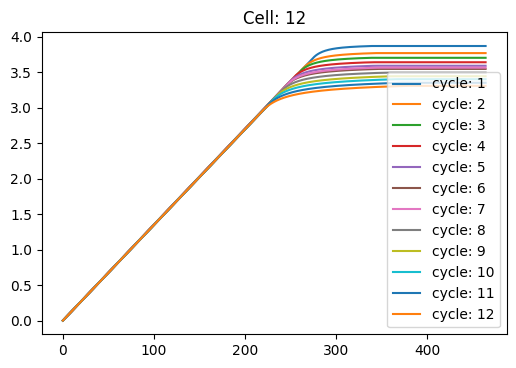

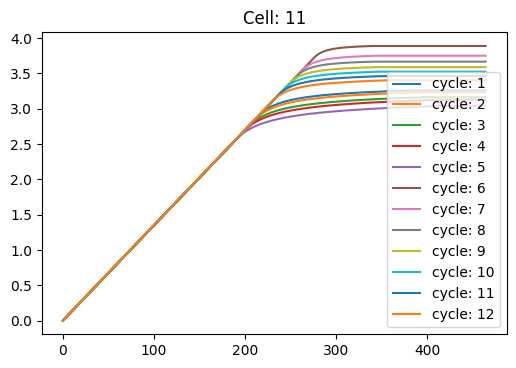

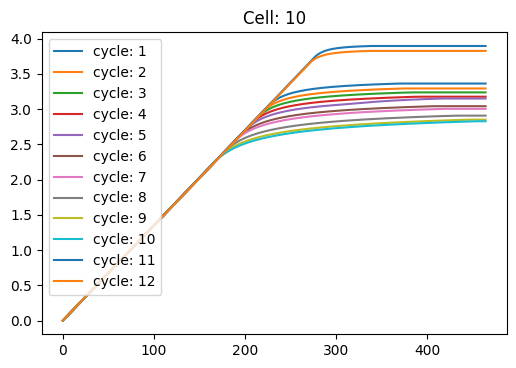

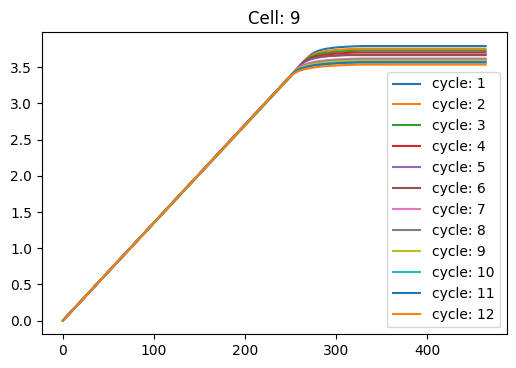

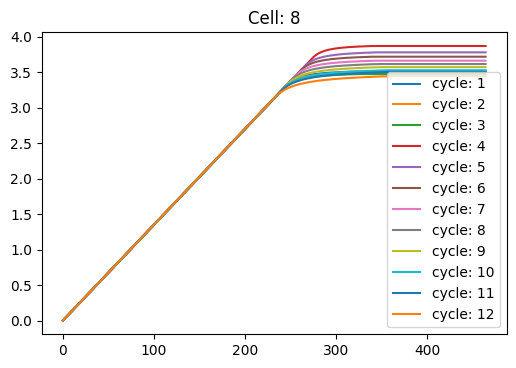

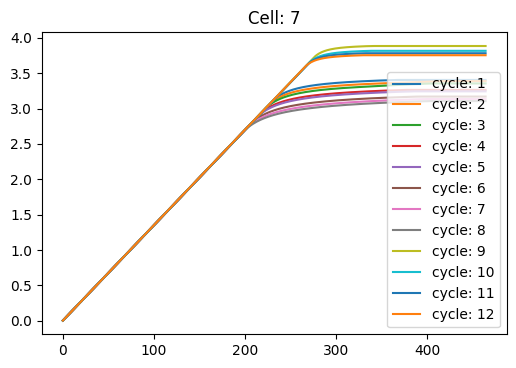

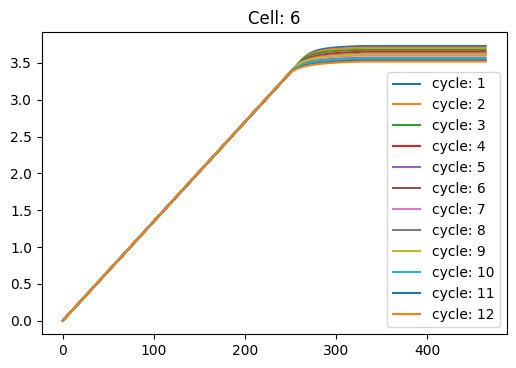

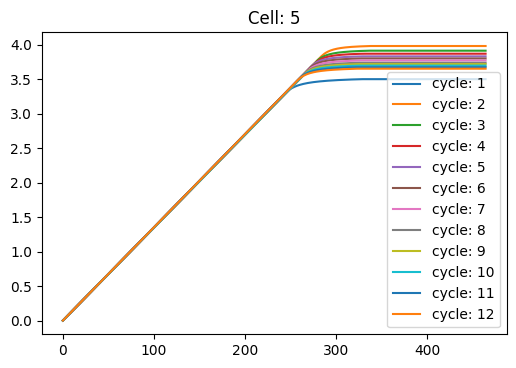

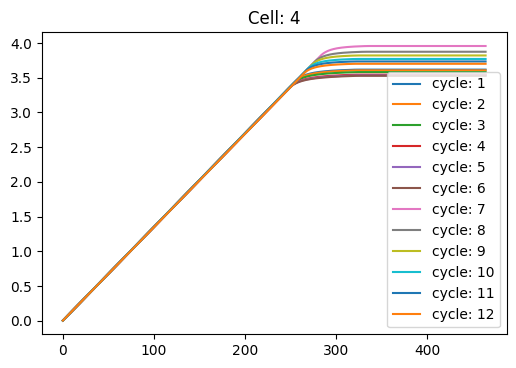

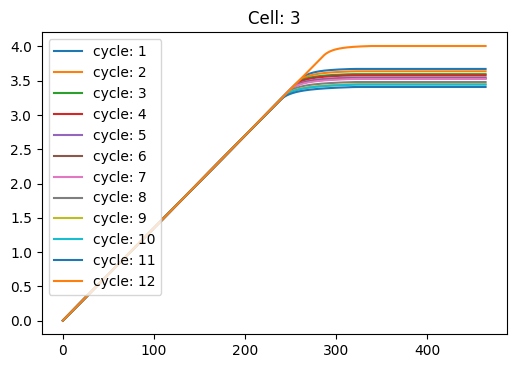

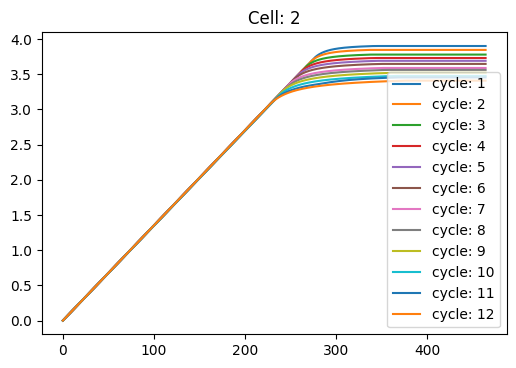

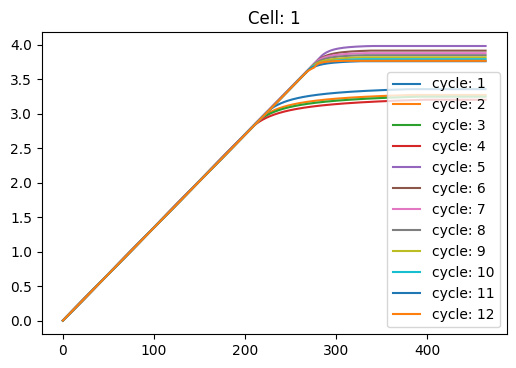

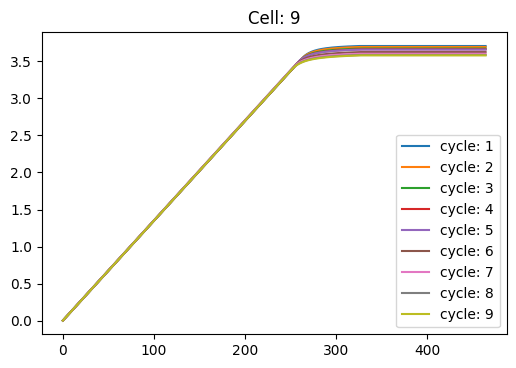

In [11]:
pcs.plot_array(cap_train_features, 2)

# Split Data into Random Partial Charge Segments

In [7]:
def lengthen_before_and_after(arr, length, time_idx, current=False):
    """
    Append voltage and current signals with with their beginning and ending values
    such that the final signal is the same length as length.
    Args:
        arr(np.array): Partial charge profile.
        length(int): Desired length of final charge profile.
        time_idx(int): Index where the beginning SOC of the charge
                       profile is first encountered.
        current(bool): If True append current with final value
                       else append with 0's.
    Returns:
        (np.array): Partial charge cycle with appendages such that
                    it is the same length as length.
    """
    end_voltage = arr[-1,0]
    start_voltage = arr[0,0]
    end_capacity = arr[-1,2]
    start_capacity = arr[0,2]
    if current:
        end_current = arr[-1,1]
        start_current = arr[0,1]
    else:
        end_current = 0
        start_current = 0
    
    after_length = length - len(arr) - time_idx
    
    before = np.concatenate((np.ones((time_idx,1))*start_voltage, 
                             np.ones((time_idx,1))*start_current, 
                             np.ones((time_idx,1))*start_capacity), axis=-1)
    
    after = np.concatenate((np.ones((after_length,1))*end_voltage, 
                            np.ones((after_length,1))*end_current, 
                            np.ones((after_length,1))*end_capacity), axis=-1)

    return np.concatenate((before, arr, after))

def remove_bias(labels, base_count, num_bins=5):
    """
    Remove bias by ensuring there is approximately the same number of SOH points in each SOH bin.
    
    See paper for explanation on bins.
    Args:
        labels(np.array): Output labels for the model.
        base_count(int): Number of times labels are sampled from
                         without bias correction.
        num_bins(int): Number of bins to seperate the label space into.
    Returns:
        count_length(dict): The number of samples for every label such that there is an approximately
                            equal number of labels in each bin.
     """
    lab_min = np.min(labels)
    lab_max = np.max(labels)
    
    # make SOH bins
    bin_width = int((lab_max - lab_min)/num_bins)
    
    bins = []
    bin_end = lab_min
    while bin_end < lab_max:
        bin_start = bin_end
        bin_end = bin_start + bin_width
        if bin_end*1.01 >= 100:
            bins.append( (bin_start, lab_max) )
            break
        bins.append( (bin_start, bin_end) )
        
    # bin lables
    binned_labels = {}
    for bin_range in bins:
        binned_labels[bin_range] = [ (idx, float(label)) for idx, label in enumerate(labels)
                                    if label >= bin_range[0] and label <= bin_range[1] ]

    # correct so that after random selection, the bins have the same number of samples
    max_key, max_value = max(binned_labels.items(), key = lambda x: len(set(x[1])))
    max_length = len(max_value)*base_count
    
    count_length = {}
    for key, value in binned_labels.items():
        count = round(max_length/len(value))
        for item in value:
            count_length[item[0]] =  count
            
    return count_length

In [8]:
def make_aligned_partial_charges(features, labels, add_full_charge=False, soc_min_features=None, 
                                 soc_max_features=None, count_length=2, rmv_bias=True, validation=False):
    """
    Create random partial charge cycles from existing characterisation charge cycles.
    Args:
        features(np.array): Input features for the model.
        labels(np.array): Output labels for the model.
        add_full_charge(bool): Include full charge data as well as partial
                               charge data iff True.
        soc_min_features(np.array): Beginning SOC of full charges in features.
        soc_max_features(np.array): Final SOC of full charges in features.
        count_length(int): Number of times all charcterisation charge cycles are sampled from.
        rmv_bial(bool): Remove bias from the dataset iff True.
    Returns:
        (tuple):
            element 0 -> features_array(np.array): Voltage and current partial charge profiles.
            element 1 -> soc_min(np.array): Minimum SOC for each charge profile.
            element 2 -> soc_max(np.array): Maximum SOC for each charge profile.
            element 3 -> vmin(np.array): Minimum voltage of each charge profile in V.
            element 4 -> vmax(np.array): Maximum voltage of each charge profile in V.
            element 5 -> cmin(np.array): Minimum capacity of each charge profile in Ah.
            element 6 -> cmax(np.array): Maximum capacity of each charge profile in Ah.
            element 7 -> labels_array(np.array): Labels for every charge profile in SOH.
            element 8 -> seg_len(np.array): Segment length of every charge profile in seconds.
    """
    # declare SOC_min and voltage check variables based on
    # if this is validation or training
    if validation:
        SOC_min_start = 30
        SOC_min_end = 80
        volt_check = 4.10
    else:
        SOC_min_start = 15
        SOC_min_end = 85
        volt_check = 4.30
    # declare variables
    features_array = []
    soc_min = []
    soc_max = []
    labels_array = []
    seg_len = []
    vmin = []
    vmax = []
    cmin = []
    cmax = []
    # minimum segment length time = seg_min*5*7 seconds
    seg_min = 50
    
    # remove bias
    if rmv_bias:
        count_dict = remove_bias(labels, count_length, num_bins=5)

    for idx, charge_profile in enumerate(features):
        data_length = len(charge_profile)
        
        if rmv_bias:
            count_length = count_dict[idx]
            
        for count in range(count_length):
            stop_bool = True
            soc_range_check = True
            while soc_range_check:
                SOC_min = random.randint(SOC_min_start, SOC_min_end)
                while stop_bool:
                    try:
                        soc_pos = np.min(np.where(np.round(charge_profile[:,2]*25) == SOC_min))
                        if (data_length - soc_pos) < seg_min: raise
                        stop_bool = False
                    except:
                        SOC_min = random.randint(SOC_min_start, SOC_min_end)
                        
                segment_length = random.randint(seg_min, 200)

                # insure that array is not too long.
                while segment_length > (data_length - soc_pos):
                    segment_length = random.randint(seg_min, (data_length - soc_pos))

                time_idx = np.min(np.where(np.round(features[0,:,2]/features[0,-1,2],2) == SOC_min/100))
                SOC_max = charge_profile[segment_length+soc_pos-1,2]
                
                if ( (SOC_max/4.0 - SOC_min/100) >= 0.10
                    and charge_profile[soc_pos,0] < volt_check):
                    soc_range_check = False
                stop_bool = True
                
            seg_len.append(segment_length)
            
            temp_crg_prof = charge_profile[soc_pos:soc_pos+segment_length,:]
            new_crg_prof = lengthen_before_and_after(temp_crg_prof, data_length, time_idx)
                
            features_array.append(new_crg_prof)
            soc_min.append(SOC_min/100)
            soc_max.append(SOC_max/4.0)
            labels_array.append(labels[idx][0])
            vmin.append(temp_crg_prof[0,0])
            vmax.append(temp_crg_prof[-1,0])
            cmin.append(temp_crg_prof[0,1])
            cmax.append(temp_crg_prof[-1,1])
    
    if add_full_charge:
        if rmv_bias:
            count_dict = remove_bias(labels, 1, num_bins=5)
            full_features = []
            full_labels = []
            for idx, charge_profile in enumerate(features):
                count_length = count_dict[idx]
                count = 0
                while count < count_length:
                    full_features.append(charge_profile)
                    full_labels.append(labels[idx][0])
                    count += 1
                    
            full_features = np.array(full_features)
            full_labels = np.array(full_labels)
            features_array = np.concatenate((full_features, np.array(features_array)), axis=0, dtype='float64')
            labels_array = np.concatenate((full_labels.reshape(-1,1), np.array(labels_array).reshape(-1,1)), axis=0, dtype='float64')
            
        else:
            features_array = np.concatenate((features, np.array(features_array)), axis=0, dtype='float64')
            labels_array = np.concatenate((labels, np.array(labels_array).reshape(-1,1)), axis=0, dtype='float64')
        soc_min = np.concatenate((soc_min_features, np.array(soc_min).reshape(-1,1)), axis=0, dtype='float64')
        soc_max = np.concatenate((soc_max_features, np.array(soc_max).reshape(-1,1)), axis=0, dtype='float64')
        vmin = np.concatenate((np.min(features[:,:,0], axis=1).reshape(-1,1), np.array(vmin).reshape(-1,1)), axis=0, dtype='float64')
        vmax = np.concatenate((np.max(features[:,:,0], axis=1).reshape(-1,1), np.array(vmax).reshape(-1,1)), axis=0, dtype='float64')
        cmin = np.concatenate((np.max(features[:,:,1], axis=1).reshape(-1,1), np.array(cmin).reshape(-1,1)), axis=0, dtype='float64')
        cmax = np.concatenate((np.max(features[:,:,1], axis=1).reshape(-1,1), np.array(cmax).reshape(-1,1)), axis=0, dtype='float64')
        
    return (np.array(features_array, dtype='float64'), 
            np.array(soc_min, dtype='float64').reshape(-1,1), 
            np.array(soc_max, dtype='float64').reshape(-1,1),
            np.array(vmin, dtype='float64').reshape(-1,1),
            np.array(vmax, dtype='float64').reshape(-1,1),
            np.array(cmin, dtype='float64').reshape(-1,1),
            np.array(cmax, dtype='float64').reshape(-1,1),
            np.array(labels_array, dtype='float64').reshape(-1,1), 
            np.array(seg_len, dtype='float64').reshape(-1,1))

In [9]:
add_full_charge = True
count_length = 5

train_tuple = make_aligned_partial_charges(cap_train_features, train_labels, add_full_charge, SOC_min_features, SOC_max_features, count_length)
val_tuple = make_aligned_partial_charges(cap_val_features, val_labels, add_full_charge, SOC_min_val, SOC_max_val, count_length,rmv_bias=False)
val_tuple1 = make_aligned_partial_charges(cap_val_features, val_labels, add_full_charge, SOC_min_val, SOC_max_val, 1, rmv_bias=False, validation=True)
MG_tuple = make_aligned_partial_charges(cap_MG_features, MG_labels, add_full_charge, SOC_min_MG, SOC_max_MG, 1, rmv_bias=False, validation=True)

In [10]:
def run_rand(boo=False, num=1, rmv_bias=False, validation=True):
    val_tuple1 = make_aligned_partial_charges(cap_val_features, val_labels, boo, SOC_min_val, SOC_max_val, num, rmv_bias=rmv_bias, validation=validation)
    MG_tuple = make_aligned_partial_charges(cap_MG_features, MG_labels, boo, SOC_min_MG, SOC_max_MG, num, rmv_bias=rmv_bias, validation=validation)
    return val_tuple1, MG_tuple

# Build SISO CNN-GPR Model

Functions for building a single input single output CNN-GPR model.

In [11]:
def build_normalizer(input_shape, train_features):
    # Make normalizer to normalize data
    normalizer = keras.layers.Normalization(input_shape=input_shape,axis=-1)
    normalizer.adapt(train_features)
    return normalizer

In [12]:
def build_cnn_model(train_features):
    """
    Build the tuned CNN model.
    Args:
        train_features(np.array): training features.
    Returns:
        cnn_model(keras.Model): tuned CNN model.
        cnn_input(keras.Input): Input to CNN model.
    """
    
    # Build the normalizer according to certain input.
    normalizer = build_normalizer(train_features.shape[1:], train_features)
    
    # Build model using Keras's Functional API to enable inputs at a later layer when we combine with the GPflux GP layer.
    cnn_input = keras.Input(shape=train_features.shape[1:], name="charge_data")
    x = normalizer(cnn_input)
    x = layers.Conv1D(5, 5, padding='same', activation='relu')(x)
    x = layers.MaxPooling1D()(x)
    x = layers.Conv1D(10, 5, padding='same', activation='relu')(x)
    x = layers.MaxPooling1D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(32, activation='relu')(x)
    cnn_output = layers.Dense(1)(x)

    cnn_model = keras.Model(cnn_input, cnn_output, name="cnn")
    
    return cnn_model, cnn_input

In [13]:
def calc_likelihood_loss_func(variance=0.1):
    """
    Provide the likelihood for the loss function.
    Args:
        variance(float): Variance of the likelihood function
    Returns:
        likelihood_container(gpflux.layers.TrackableLayer): likelihood layer for tracking the likelihood variance.
        loss(gpflux.losses.LikelihoodLoss): Loss function for optimization.
    """
    # Build the likelihood loss function for optimization
    likelihood = gpflow.likelihoods.Gaussian(variance)

    # So that Keras can track the likelihood variance, we need to provide the likelihood as part of a "dummy" layer:
    likelihood_container = gpflux.layers.TrackableLayer()
    likelihood_container.likelihood = likelihood

    # Provide loss function for optimization
    loss = gpflux.losses.LikelihoodLoss(likelihood)
    
    return likelihood_container, loss

In [14]:
def build_siso_gp_layer(train_labels, kernel, num_inducing=10, lengthscales=2, num_data=250):
    """
    Build a 1 input 1 output GP layer using GPflux.
    Args:
        train_labels(np.array): Output training labels.
        kernel(str): Selected Kernel type. Can be RBF, Periodic, RBF+Periodic, RBF+Linear. Linear+Periodic.
        num_inducing(int): Number of inducing points for the sparce Gaussian process.
        lengthscales(float): lengthscales for the squared exponential kernel.
        num_data(int): Number of data for constructing gpflux GPLayer.
    Returns:
        gp_layer(gpflux.layers.GPLayer): Gaussian process layer.
    """

    # make kernel.
    RBF_kernel = gpflow.kernels.SquaredExponential(lengthscales=lengthscales) # pass an array of lengthscales to allow for multiple inputs
    Periodic_kernel = gpflow.kernels.Periodic(RBF_kernel, period=10)
    Lin_kernel = gpflow.kernels.Linear()
    
    if kernel == 'RBF':
        kernel = RBF_kernel
    elif kernel == 'Periodic':
        kernel = Periodic_kernel
    elif kernel == 'Linear':
        kernel = Lin_kernel
    elif kernel == 'RBF+Periodic':
        kernel = RBF_kernel + Periodic_kernel
    elif kernel == 'RBF+Linear':
        kernel = RBF_kernel + Lin_kernel
    elif kernel == 'Linear+Periodic':
        kernel = Lin_kernel + Periodic_kernel
        
    # make inducing variables
    inducing_variable = gpflow.inducing_variables.InducingPoints(
        np.linspace(train_labels.min(), train_labels.max(), num_inducing).reshape(-1, 1)
    )

    # make mean function using approximate input data
    mean_func = gpflux.helpers.construct_mean_function(
        train_labels,
        D_in=1,
        D_out=1
    )

    # build GP layer.
    gp_layer = gpflux.layers.GPLayer(
        kernel, inducing_variable, num_data=num_data, num_latent_gps=1, mean_function=mean_func
    )
    
    return gp_layer

In [15]:
def build_gp_model(gp_layer, input_shape=(1,), likelihood_container=None):
    """
    Builds a gp model from a gp_layer and corresponding input_shape.
    Args:
        gp_layer(gpflux.layers.GPLayer): gpflux Gaussian process layer to be added to the model.
        input_shape(tuple): Number of inputs to the Gaussian process layer.
    Returns:
        gp_model(keras.Model): Keras model consisting of the GP input and output.
    """
    
    gp_input = keras.Input(shape=input_shape, name="gp_input")
    gp_output = gp_layer(gp_input)
    
    if likelihood_container is not None:
        gp_output = likelihood_container(gp_output)

    gp_model = keras.Model(gp_input, gp_output, name="gp_model")
    
    return gp_model

In [16]:
def build_siso_cnn_gp_model(cnn_model, gp_model, likelihood_container, cnn_input):
    """
    Build a combined CNN and GPR single input single output model.
    Args:
        cnn_model(keras.Model): Keras CNN model.
        gp_model(keras.Model): Keras/gpflux GP model.
        likelihood_container(gpflux.layers.TrackableLayer): likelihood layer for tracking the likelihood variance.
        cnn_input(keras.Input): Input to cnn_model.
    Returns:
        cnn_gp_model(keras.Model): Combined CNN-GPR model ready to be compiled and trained.
    """
    # Combine CNN and GP models into one model.
    cnn_out = cnn_model(cnn_input)
    x = gp_model(cnn_out)
    combined_output = likelihood_container(x)

    cnn_gp_model = keras.Model(
        inputs=cnn_input,
        outputs=combined_output,
        name="cnn_gp"
    )
    
    return cnn_gp_model

# Analyze Results

Functions for plotting results.

In [17]:
def plot_cnn_gp(model, X, Y, ylim=None, color='black', scatter=False, ax=None):
    """
    Plot the predicted SOH of the CNN-GPR vs the measured SOH.
    Args:
        model(keras.Model): Instance of a trained CNN-GPR model.
        X(np.array): Input data to the model.
        Y(np.array): Measured model output.
        ylim(list): [min, max] y-axes limits.
        color(str): Color of the plot lines.
        scatter(bool): Scatter plot if True, else line plot.
        ax(plt.Figure.Axes): Figure axes to be plotted on. For subplots.
    """
    x = np.arange(0, len(Y))
    f_distribution = model(X)
    mean = f_distribution.mean().numpy().squeeze()
    var = f_distribution.variance().numpy().squeeze() + model.layers[-1].likelihood.variance.numpy()
    err = 2 * np.sqrt(var)
    lower = mean - err
    upper = mean + err
    
    if ax is not None:
        # ax.plot(Y, "kx", alpha=0.5)
        if scatter:
            # ax.plot(mean, 'o', color=color)
            ax.errorbar(x, mean, yerr=err, fmt='k+', capsize=3.5, zorder=10, linewidth=2)
        else:
            ax.plot(mean, color=color)
            ax.fill_between(x, lower, upper, color=color, alpha=0.3)

        if ylim is not None:
            ax.set_ylim(ylim)
        
        # plot true points    
        ax.scatter(x,Y, marker="o", color='orange', zorder=9)
        ax.grid()
        return
    
    if scatter:
        # plt.plot(mean, 'o', color=color)
        plt.errorbar(x, mean, yerr=err, fmt='k+', capsize=3, zorder=10)
    else:
        plt.plot(mean, color=color)
        plt.fill_between(x, lower, upper, color=color, alpha=0.3)
        
    # plot true points    
    plt.scatter(x,Y, marker="o", color='orange', zorder=9)
    
    if ylim is not None:
        plt.ylim(ylim)
    print(f'MAE: {np.sum(abs(Y - mean.reshape(-1,1))/len(Y))}')
    print(f'MSE: {np.sum((Y - mean.reshape(-1,1))**2/len(Y))}')
    print(f'Max Error: {np.max(abs(Y - mean.reshape(-1,1)))}')

In [18]:
def plot_soc(val_tuple1, seg=True, soc=True, voltage=False):
    """
    Plot the soc_min and soc_max plot, as well as segment lenght and voltage min max.
    Args:
        val_tuple1(tuple): Partial charge input data tuple.
        seg(bool): Plot segment length iff True.
        soc(bool): Plot soc min and max iff True.
        voltage(bool): Plot voltage max and min iff True and soc is False.
    """
    
    %matplotlib widget
    fig, ax1 = plt.subplots(figsize=(10,8))
    ax2 = ax1.twinx()

    if soc:
        ln1 = ax1.plot(np.arange(0,len(val_tuple1[-2])), val_tuple1[1], marker='*', label='SOC Min')
        ln2 = ax1.plot(np.arange(0,len(val_tuple1[-2])), val_tuple1[2], marker='x', label='SOC Max')
        if seg:
            ln3 = ax2.plot(np.arange(0,len(val_tuple1[-2])), val_tuple1[-1]*7*5/60, marker='o', alpha=0.3, label='Segment Length')
            ax2.set_ylabel('Segment Length [min]', fontsize=16)
        # ax1.set_title('Charge Segment Details', fontsize=16)
        ax1.set_xlabel('Partial Charge Segment Sample', fontsize=16)
        ax1.set_ylabel('SOC [%]', fontsize=16)
        
        lns = ln1+ln2+ln3
        labs = [l.get_label() for l in lns]
        ax1.legend(lns, labs, fontsize=16)
        plt.show()
        fig.savefig('your/path/here', dpi=300)
            
    elif voltage:
        ax1.plot(np.arange(0,len(val_tuple1[-2])), val_tuple1[4], marker='*')
        ax2.plot(np.arange(0,len(val_tuple1[-2])), val_tuple1[6], marker='x', color='orange')
        if seg:
            ax2.plot(np.arange(0,len(val_tuple1[-2])), val_tuple1[-1]*7*5/60, marker='o', alpha=0.3)
    

In [58]:
def plot_cnn_gp_SOH_vs_SOH(cnn_model, cnngpr_model, X, Y, independent_gp=False, save=None):
    # %matplotlib widget
    start = 0
    end = -1
    x = np.arange(0, len(Y))
    if independent_gp:
        f_distribution = cnngpr_model(cnn_model(X))
    else:
        f_distribution = cnngpr_model(X)
    mean = f_distribution.mean().numpy().squeeze()
    var = f_distribution.variance().numpy().squeeze() + cnngpr_model.layers[-1].likelihood.variance.numpy()
    lower = mean - 2 * np.sqrt(var)
    upper = mean + 2 * np.sqrt(var)
    
    SOH_predict = cnn_model(X).numpy().ravel()
    line = np.linspace(min(np.min(SOH_predict[start:end]), np.min(Y[start:end])),
                       max(np.max(SOH_predict[start:end]), np.max(Y[start:end])),
                       100)
    
    # concatenate arrays and sort
    Y_sorted = np.vstack((SOH_predict[start:end], Y[start:end].ravel())).T
    mean_sorted = np.vstack((SOH_predict[:end], mean[:end].ravel())).T
    Y_sorted = np.sort(Y_sorted, axis=0)
    mean_sorted = np.sort(mean_sorted, axis=0)
    
    fig, ax = plt.subplots(figsize=(9,7))
    # ax2 = ax.twinx()
    ax.scatter(Y_sorted[:,0], Y_sorted[:,1], label=r'Measured SOH', alpha=0.25)
    # plt.plot(mean_sorted[:,0], mean_sorted[:,1], color='orange', alpha=1, label='GPR mean', linewidth=2.5)
    ax.plot(mean_sorted[:,0], mean_sorted[:,1], color='orange', alpha=1, label=r'$SO \widehat{H_{CNN}} _{-GPR}$ $mean$', linewidth=2.5)
    ax.fill_between(mean_sorted[:,0], mean_sorted[:,1] - 2 * np.sqrt(var)[:-1], mean_sorted[:,1] + 2 * np.sqrt(var)[:-1], 
                     color='orange', alpha=0.3, label=r'$SO \widehat{H_{CNN}} _{-GPR}$ $2\sigma$ $bound$')
    # plt.plot(line, line, linestyle='--', color='grey', label='Desired prediction')
    ax.legend(fontsize=15, fancybox=True, shadow=True)
    ax.set_xlabel(r'$SO \widehat{H_{CN}} _N$ [%]', fontsize=16)
    ax.set_ylabel(r'SOH [%]', fontsize=16)
    # ax2.set_ylabel(r'$SO \widehat{H_{CNN}} _{-GPR}$ [%]', fontsize=16)
    ax.tick_params(labelright=False, labelsize=16)
    # ax.yaxis.set_ticks_position('both')
    # ax2.tick_params(axis='y',colors='white')
    ax.set_ylim(66, 104)
    ax.set_xlim(46, 104)
    
    if save is not None:
        fig.savefig(save, dpi=300)

In [20]:
def plot_cnn_gp_3D(model, X, Y):
    """
    Plot 3D interpretation of CNN-GPR output. Essentially a Gaussian distrubition overlayed
    on the predicted SOH.
    Args:
        model(keras.Model): Instance of a trained CNN-GPR model.
        X(np.array): Input data to the model.
        Y(np.array): Measured model output.
    """
    # collect function distribution and smaple from it with SOH points.
    x = np.arange(0, len(Y))
    f_distribution = model(X)
    mean = f_distribution.mean().numpy().squeeze()
    var = f_distribution.variance().numpy().squeeze() + model.layers[-1].likelihood.variance.numpy()
    sigma = np.sqrt(var)
    # print(sigma)
    lower = mean - 5 * np.sqrt(var)
    upper = mean + 5 * np.sqrt(var)
    
    # plot 3D distribuition
    fig = plt.figure(figsize = (12,10))
    ax = plt.axes(projection='3d')

    x_dist = []
    for idx, m in enumerate(mean):
        x_dist.append(np.concatenate((np.arange(lower[idx], m,  0.2), np.arange(m, upper[idx], 0.2))))
        
    x_dist = np.array(x_dist)

    Z = []
    for idx, m in enumerate(mean):
        Z.append(1/( sigma[idx] * np.sqrt(2*np.pi) )*np.exp( -0.5*((x_dist[idx] - m)/sigma[idx])**2 )) # gaussian distribuition
    Z = np.array(Z)
    Z_zero = np.zeros((len(x)))
    
    mean_line = ax.plot3D(x, mean, Z_zero)
    true_points = ax.scatter(x, Y, Z_zero)
    gaussian_surface = ax.plot_surface(x.reshape(-1,1), x_dist, Z, alpha=0.2)
    gaussian_surface = ax.plot_wireframe(x.reshape(-1,1), x_dist, Z, alpha=0.3)
    
    # Set axes label
    ax.set_xlabel('x', labelpad=20)
    ax.set_ylabel('y', labelpad=20)
    ax.set_zlabel('z', labelpad=20)

    # fig.colorbar(gaussian_surface, shrink=0.5, aspect=8, alpha=0.2)

    plt.show()

[0.70079625 0.70079625 0.70079625 0.70079625 0.70079625 0.70079625
 0.70079625 0.70079625 0.70079625 0.70079625 0.70079625]


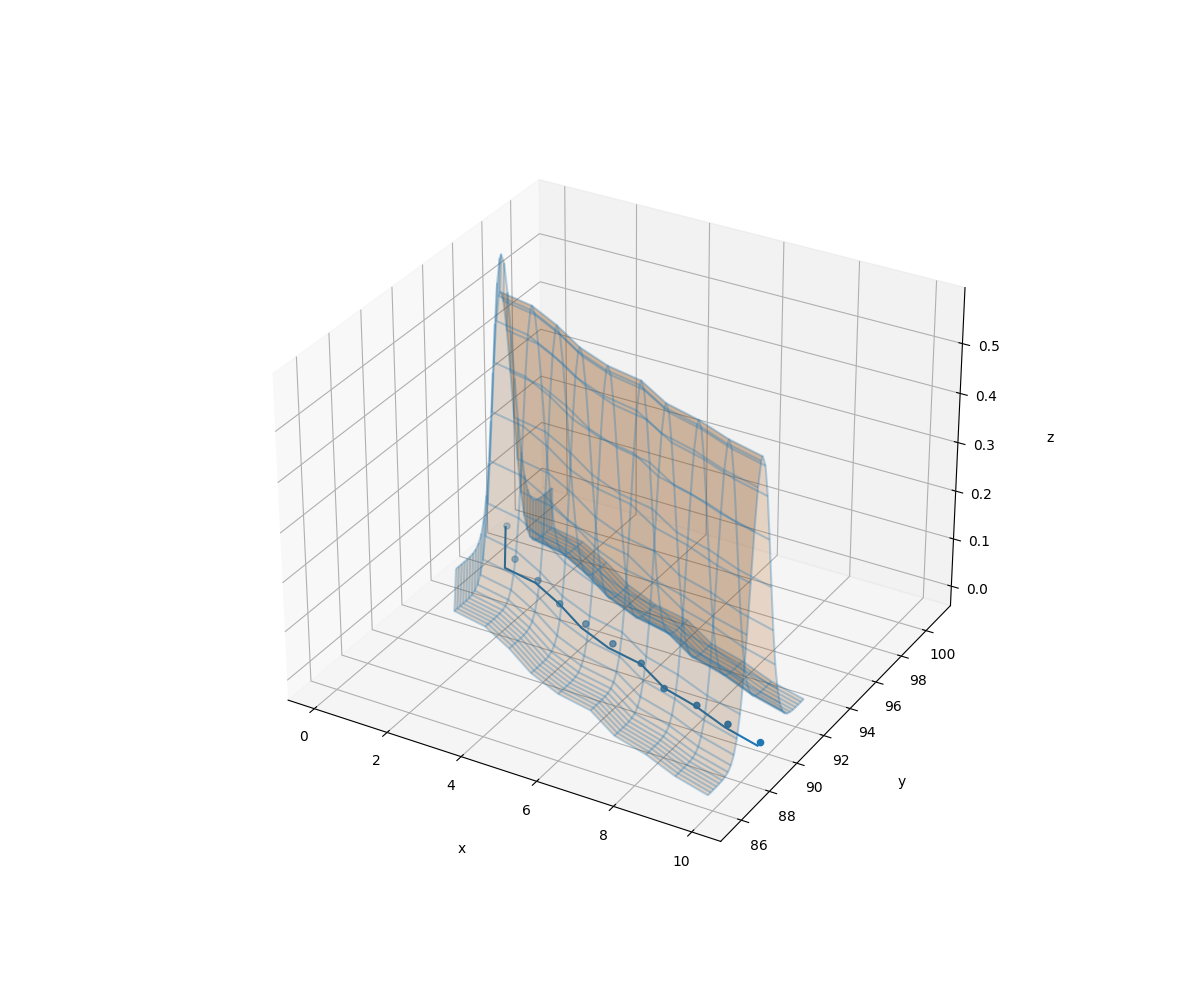

In [399]:
%matplotlib widget
plot_cnn_gp_3D(cnn_gp_pc, [val_tuple[0][:11,:,:2], val_tuple[1][:11,:], val_tuple[2][:11,:]], val_tuple[-1][:11,:])
# plot_cnn_gp_3D(cnn_gp_pc, [MG_tuple[0][:11,:,:2], MG_tuple[1][:11,:], MG_tuple[2][:11,:]], MG_tuple[-1][:11,:])

# Build SISO Model

The model can either be trained or a pre-trained model can be loaded from a file.

In [56]:
# only necessary if one wants to retrain the model with a clean slate.
tf.keras.backend.clear_session()
del siso_cnn_model_pc, siso_gp_layer_pc, siso_gp_model_pc, siso_cnn_gp_pc, likelihood_container, loss

In [21]:
# Build the model
def build_cnn_gp_model(train_tuple, kernel):
    siso_cnn_model_pc, siso_cnn_input = build_cnn_model(train_tuple[0][:,:,:2])
    likelihood_container, loss = calc_likelihood_loss_func(variance=0.5)
    siso_gp_layer_pc = build_siso_gp_layer(train_tuple[-2], kernel=kernel, num_inducing=20, num_data=len(train_tuple[-2]))
    siso_gp_model_pc = build_gp_model(siso_gp_layer_pc, input_shape=(1,))
    siso_cnn_gp_pc = build_siso_cnn_gp_model(siso_cnn_model_pc, siso_gp_model_pc, likelihood_container, siso_cnn_input)
    return siso_cnn_gp_pc

In [ ]:
siso_cnn_gp_pc = build_cnn_gp_model(train_tuple, 'Linear')

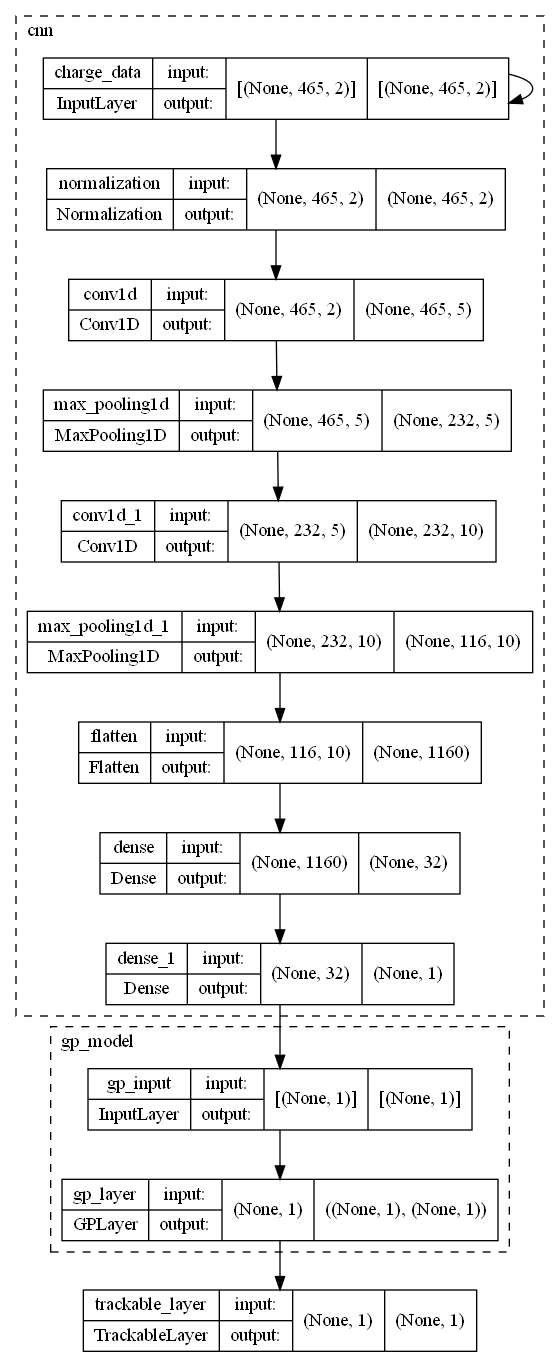

In [21]:
# plot the model architecture
plot_model(siso_cnn_gp_pc, show_shapes=True, expand_nested=True)

## Compile and Train Model

In [215]:
# Compile and train the model
siso_cnn_gp_pc.compile(loss=loss, optimizer="adam")
siso_hist = siso_cnn_gp_pc.fit(
    train_tuple[0][:,:,:2], 
    train_tuple[-2], 
    validation_data=(val_tuple[0][:,:,:2], val_tuple[-2]), 
    epochs=100, 
    verbose=0
)

(0.0, 10.0)

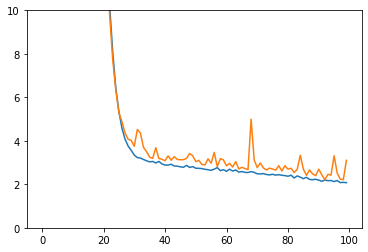

In [216]:
# plot the loss curve
%matplotlib inline
plt.plot(siso_hist.history["loss"])
plt.plot(siso_hist.history["val_loss"])
plt.ylim([0, 10])

In [ ]:
plot_cnn_gp_SOH_vs_SOH(siso_cnn_model_pc, siso_cnn_gp_pc, train_tuple[0][:,:,:2], train_tuple[-2])

MAE: 0.5583962984292956
MSE: 0.500036975222311
Max Error: 3.467819706868923


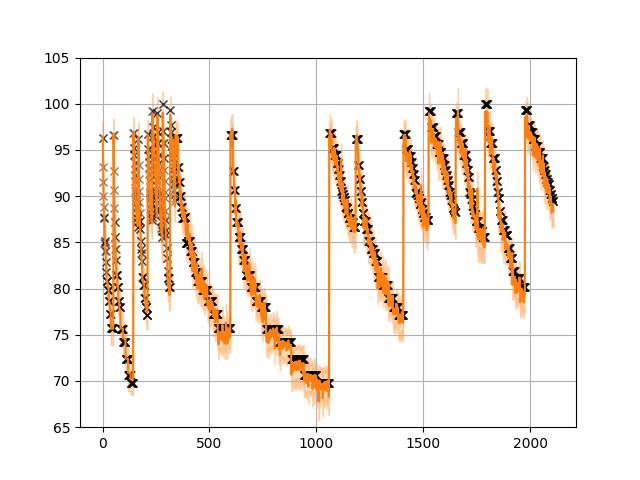

In [205]:
%matplotlib widget
plot_cnn_gp(siso_cnn_gp_pc, train_tuple[0][:,:,:2], train_tuple[-2], ylim=[65, 105])
plt.grid()
plt.show()

## Load Pre-Trained Model From File

If you would rather use the pre-trained model from the paper than train your own model use the line of code below and don't train the recently built model.

In [23]:
# Uncomment below to load the trained model from the paper.
siso_cnn_gp_pc.load_weights(os.path.join(dir_path, 'CNN-GPR Model', 'Linear', 'cnn_gp_15_85_50_200'))

## Evaluate Model

In [82]:
# Calculate new random partial charge inputs
val_tuple1, MG_tuple = run_rand(boo=False, validation=True)

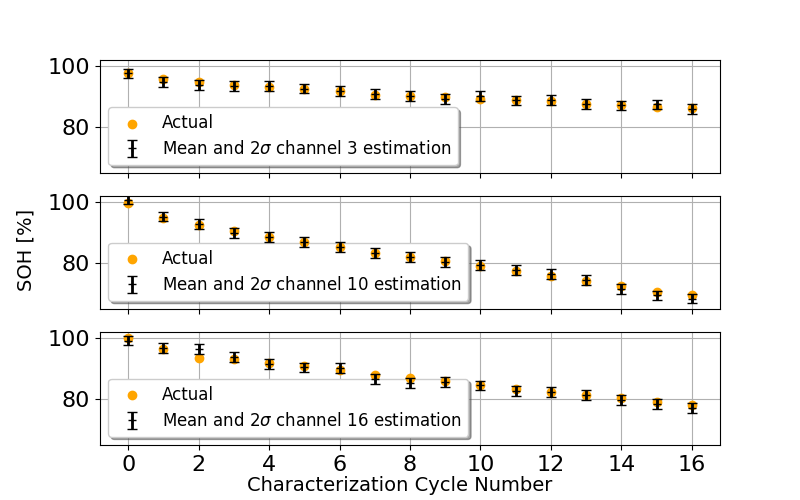

In [85]:
%matplotlib widget
fig, ax = plt.subplots(3, 1, figsize=(8,5), sharex=True, sharey=True)
prev_point = val_tuple1[-2][0]
count = 0
prev_idx = 0
cells=[2,8,11]
channels = [3,10,16]
for idx, point in enumerate(val_tuple1[-2]):
    
    if point - prev_point > 10:
        plot_cnn_gp(siso_cnn_gp_pc, val_tuple1[0][prev_idx:idx,:,:2], val_tuple1[-2][prev_idx:idx], ax=ax[count], ylim=[65, 102], scatter=True)
        ax[count].legend(['Actual', r'Mean and $2\sigma$' + f' channel {channels[count]} estimation', f'2-sigma confidence bound'],
                         loc='lower left', fontsize=12, fancybox=True, shadow=True)
        ax[count].xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        ax[count].tick_params(labelsize=16)
        count += 1
        prev_idx = idx
        
    prev_point = point
    
plot_cnn_gp(siso_cnn_gp_pc, val_tuple1[0][prev_idx:,:,:2], val_tuple1[-2][prev_idx:], ax=ax[-1], ylim=[65, 102], scatter=True)
ax[count].legend(['Actual', r'Mean and $2\sigma$' + f' channel {channels[count]} estimation', f'2-sigma confidence bound'],
                         loc='lower left', fontsize=12, fancybox=True, shadow=True)
ax[count].xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax[count].tick_params(labelsize=16)

fig.supylabel('SOH [%]', fontsize=14)
fig.supxlabel('Characterization Cycle Number', fontsize=14);

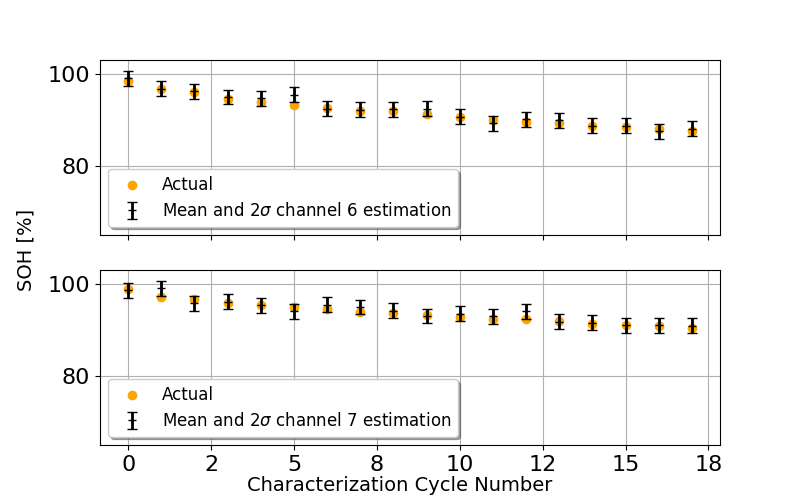

In [86]:
%matplotlib widget
fig, ax = plt.subplots(2, 1, figsize=(8,5), sharex=True, sharey=True)
prev_point = MG_tuple[-2][0]
ylim = [65,103]
count = 0
prev_idx = 0
cells=[14,15]
channels = [6,7]
for idx, point in enumerate(MG_tuple[-2]):

    if point - prev_point > 10:
        plot_cnn_gp(siso_cnn_gp_pc, MG_tuple[0][prev_idx:idx,:,:2], MG_tuple[-2][prev_idx:idx], ax=ax[count], ylim=ylim, scatter=True)
        ax[count].legend(['Actual', r'Mean and $2\sigma$' + f' channel {channels[count]} estimation'],
                         loc='lower left', fontsize=12, fancybox=True, shadow=True)
        ax[count].xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        ax[count].tick_params(labelsize=16)
        count += 1
        prev_idx = idx

    prev_point = point

plot_cnn_gp(siso_cnn_gp_pc, MG_tuple[0][prev_idx:,:,:2], MG_tuple[-2][prev_idx:], ax=ax[-1], ylim=ylim, scatter=True)
ax[count].legend(['Actual', r'Mean and $2\sigma$' + f' channel {channels[count]} estimation'],
                         loc='lower left', fontsize=12, fancybox=True, shadow=True)
ax[count].xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax[count].tick_params(labelsize=16)

fig.supylabel('SOH [%]', fontsize=14)
fig.supxlabel('Characterization Cycle Number', fontsize=14);

In [66]:
val = [[],[]]
mg = [[],[]]
for i in range(0,100):
    val_tuple1, MG_tuple = run_rand(boo=False, validation=True)
    
    val_mean = siso_cnn_gp_pc(val_tuple1[0][:,:,:2]).mean().numpy().squeeze()
    val[0].append(np.sum(abs(val_tuple1[-2] - val_mean.reshape(-1,1))/len(val_tuple1[-2])))
    val[1].append(np.max(abs(val_tuple1[-2] - val_mean.reshape(-1,1))))
    
    mg_mean = siso_cnn_gp_pc(MG_tuple[0][:,:,:2]).mean().numpy().squeeze()
    mg[0].append(np.sum(abs(MG_tuple[-2] - mg_mean.reshape(-1,1))/len(MG_tuple[-2])))
    mg[1].append(np.max(abs(MG_tuple[-2] - mg_mean.reshape(-1,1))))

Average MAE static: 0.6055346997323466
Average MaxE static: 2.4607193800726312
Average MAE dynamic: 0.6416731983604401
Average MaxE dynamic: 2.114518181330939
Max Error static: 4.470738152963463
Max Error dynamic: 3.358343549203255


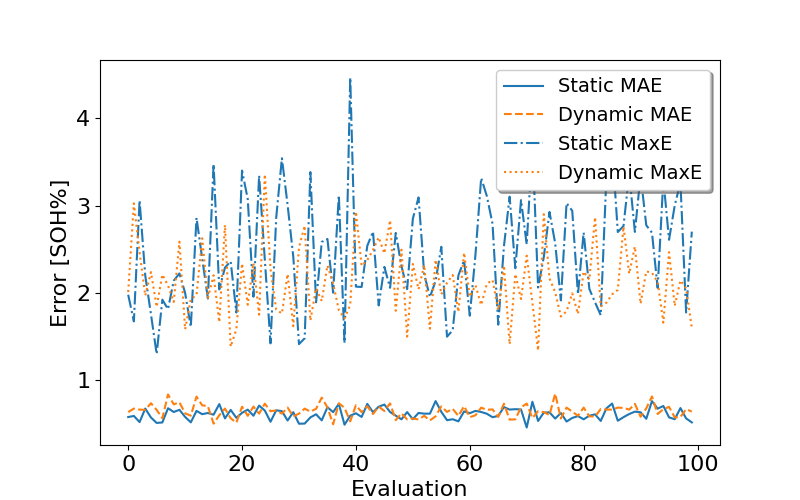

In [70]:
%matplotlib widget
fig = plt.figure(figsize=(8,5))
plt.plot(val[0], label='Static MAE', color='tab:blue')
plt.plot(mg[0], label='Dynamic MAE', color='tab:orange', linestyle='--')
# plt.subplot(122)
plt.plot(val[1], label='Static MaxE', color='tab:blue', linestyle='-.')
plt.plot(mg[1], label='Dynamic MaxE', color='tab:orange', linestyle=':')
plt.xlabel('Evaluation', fontsize=16)
plt.ylabel('Error [SOH%]', fontsize=16)
plt.tick_params(labelsize=16)
plt.legend(loc='upper right', fontsize=14, fancybox=True, shadow=True);
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.0f'));

print(f"Average MAE static: {np.sum(val[0])/len(val[0])}")
print(f"Average MaxE static: {np.sum(val[1])/len(val[1])}")
print(f"Average MAE dynamic: {np.sum(mg[0])/len(mg[0])}")
print(f"Average MaxE dynamic: {np.sum(mg[1])/len(mg[1])}")
print(f"Max Error static: {np.max(val[1])}")
print(f"Max Error dynamic: {np.max(mg[1])}")

# Independent CNN and GPR Modellig

## Just CNN Model

In [83]:
def predict_and_plot(model, features, labels):
    prediction = model.predict(features)
    mlplt.plot_prediction_and_error(prediction, labels, figsize=(10,5), scatter=True)
    return prediction

In [41]:
# Uncomment and run if you want to retraint the model
# tf.keras.backend.clear_session()
# del cnn_model

(0.0, 10.0)

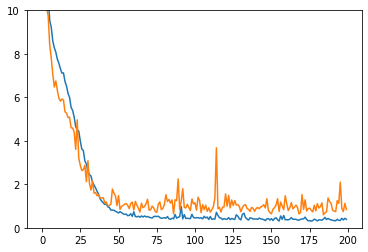

In [42]:
cnn_model, _ = build_cnn_model(train_tuple[0][:,:,:2])
cnn_model.compile(loss='mse', optimizer='adam')
cnn_hist = cnn_model.fit(train_tuple[0][:,:,:2], train_tuple[-2], validation_data=(val_tuple[0][:,:,:2], val_tuple[-2]), epochs=200, verbose=0)

%matplotlib inline
plt.plot(cnn_hist.history["loss"])
plt.plot(cnn_hist.history["val_loss"])
plt.ylim([0, 10])

## Just GP Models

In [39]:
linear_cnngp = build_cnn_gp_model(train_tuple, 'Linear')
rbf_cnngp = build_cnn_gp_model(train_tuple, 'RBF')
rbf_linear_cnngp = build_cnn_gp_model(train_tuple, 'RBF+Linear')

C:\Users\seanb\AppData\Local\Temp/ipykernel_22632/107000946.py:14: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2.5, `tf.Module` supports this natively and there is no need for `TrackableLayer` anymore. It will be removed in GPflux version `1.0.0`.)
  likelihood_container = gpflux.layers.TrackableLayer()
c:\Users\seanb\anaconda3\envs\batmodel\lib\site-packages\gpflux\layers\gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=1` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


In [56]:
# Uncomment below to load the trained model from the paper.
linear_cnngp.load_weights(os.path.join(dir_path, 'CNN-GPR Model', 'Linear', 'cnn_gp_15_85_50_200'))
rbf_cnngp.load_weights(os.path.join(dir_path, 'CNN-GPR Model', 'RBF', 'cnn_gp_15_85_50_200'))
rbf_linear_cnngp.load_weights(os.path.join(dir_path, 'CNN-GPR Model', 'Linear-RBF', 'cnn_gp_15_85_50_200'))

In [38]:
tf.keras.backend.clear_session()
del rbf_linear_cnngp, cnn_model, rbf_cnngp, linear_cnngp

In [36]:
def build_standalone_gp(train_tuple, val_tuple, kernel, cnn_model, plot=False):
    likelihood_container, loss = calc_likelihood_loss_func(variance=0.5)
    gp_layer = build_siso_gp_layer(train_tuple[-2], kernel=kernel, num_inducing=20, num_data=len(train_tuple[-2]))
    gp_model = build_gp_model(gp_layer, input_shape=(1,), likelihood_container=likelihood_container)

    gp_input = cnn_model(train_tuple[0][:,:,:2])
    gp_val_input = cnn_model(val_tuple[0][:,:,:2])

    # Compile and train the model
    gp_model.compile(loss=loss, optimizer="adam")
    gp_hist = gp_model.fit(
        gp_input, 
        train_tuple[-2], 
        validation_data=(gp_val_input, val_tuple[-2]), 
        epochs=200, 
        verbose=0
    )

    if plot:
        %matplotlib inline
        plt.plot(gp_hist.history["loss"])
        plt.plot(gp_hist.history["val_loss"])
        plt.ylim([0, 10])

    return gp_model

In [43]:
linear_gp = build_standalone_gp(train_tuple, val_tuple, 'Linear', cnn_model)
rbf_gp = build_standalone_gp(train_tuple, val_tuple, 'RBF', cnn_model)
rbf_linear_gp = build_standalone_gp(train_tuple, val_tuple, 'RBF+Linear', cnn_model)

C:\Users\seanb\AppData\Local\Temp/ipykernel_22632/107000946.py:14: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2.5, `tf.Module` supports this natively and there is no need for `TrackableLayer` anymore. It will be removed in GPflux version `1.0.0`.)
  likelihood_container = gpflux.layers.TrackableLayer()


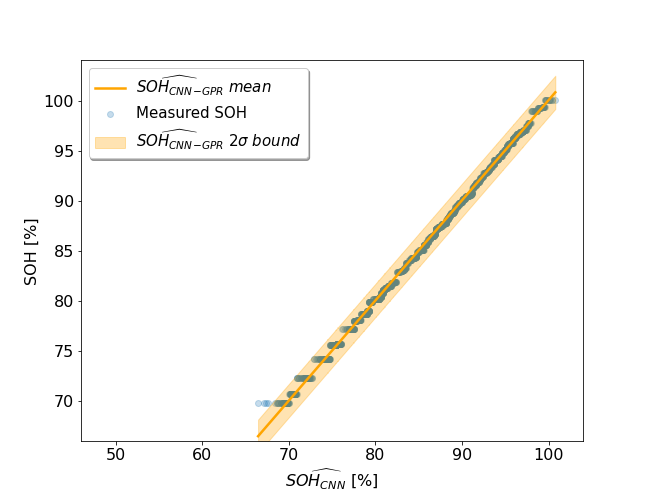

In [63]:
%matplotlib widget
plot_cnn_gp_SOH_vs_SOH(cnn_model, linear_gp, train_tuple[0][:,:,:2], train_tuple[-2], independent_gp=True,
                      save=None)

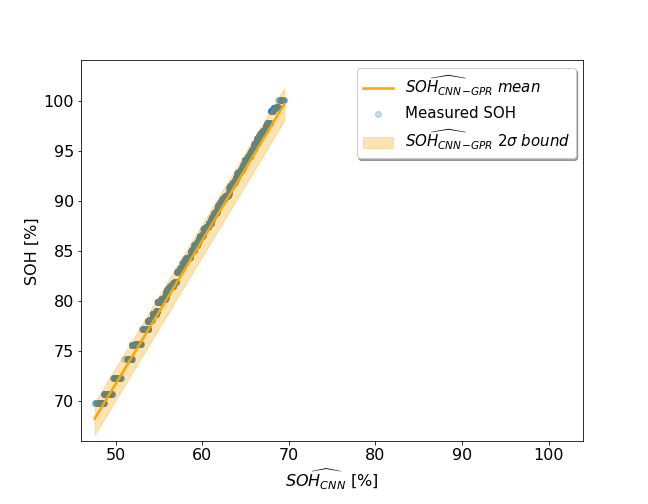

In [64]:
%matplotlib widget
plot_cnn_gp_SOH_vs_SOH(linear_cnngp.get_layer('cnn'), linear_cnngp, train_tuple[0][:,:,:2], train_tuple[-2], independent_gp=False,
                      save=None)

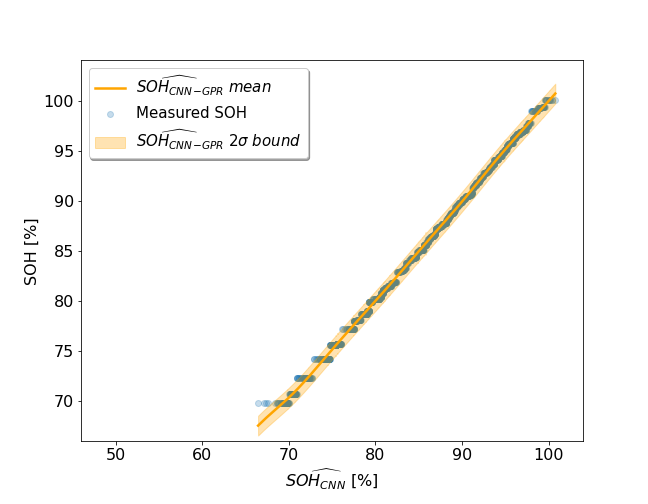

In [65]:
%matplotlib widget
plot_cnn_gp_SOH_vs_SOH(cnn_model, rbf_gp, train_tuple[0][:,:,:2], train_tuple[-2], independent_gp=True,
                      save=None)

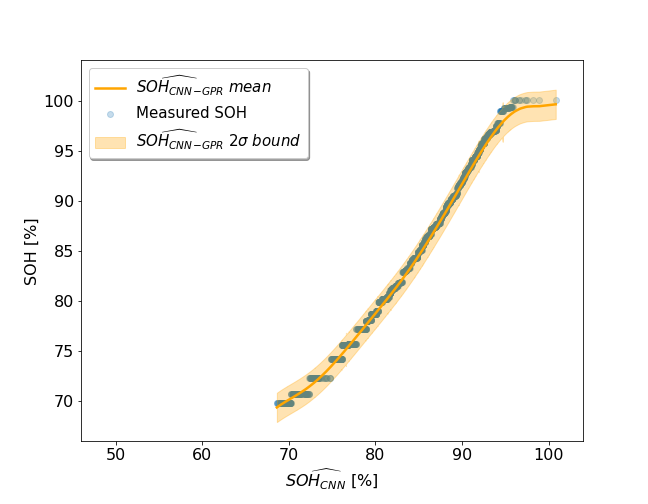

In [66]:
%matplotlib widget
plot_cnn_gp_SOH_vs_SOH(rbf_cnngp.get_layer('cnn'), rbf_cnngp, train_tuple[0][:,:,:2], train_tuple[-2], independent_gp=False,
                      save=None)